# Model selection  with Naive featuring 
#  Quora Question Pairs
# Identification of  question pairs that have the same intent.

The purpose of this project is to understand this data and to select predictive 

model using naive featuring and RandomizedSearchCV  for hyperparameters tuning.

This notebook is organized as followed

1. A quick look at the data

2. Feature engineering

3.  Models selection and hyperparameters tuning

Submission

Importation of libraries and load data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="white", color_codes=True)
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
import sklearn 
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# 1. A quick look at the data

In [3]:
train.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404289 non-null object
question2       404288 non-null object
is_duplicate    404290 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [5]:
train.groupby('is_duplicate').count()

,id,qid1,qid2,question1,question2
is_duplicate,,,,,
0,255027,255027,255027,255026,255025
1,149263,149263,149263,149263,149263


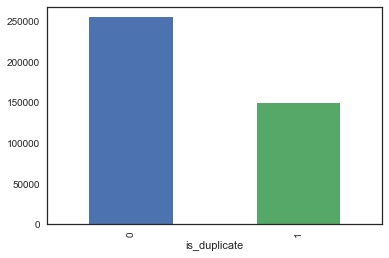

In [6]:
train.groupby("is_duplicate")['id'].count().plot.bar(ylim=0)
plt.show()

Data is imbalanced.  Before rebalancing it, we fill nan with " " the empty string.

In [7]:
train = train.fillna(" ")

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404290 non-null object
question2       404290 non-null object
is_duplicate    404290 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [9]:
from sklearn.utils import resample

In [10]:
train_majority = train[train["is_duplicate"]== 0]
train_minority = train[train["is_duplicate"]== 1]

In [11]:
# Upsample minority class
train_minority_upsampled = resample(train_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=255027,    # to match majority class
                                 random_state=1230) # reproducible results
 

In [12]:
# Combine majority class with upsampled minority class
train_upsampled = pd.concat([train_majority, train_minority_upsampled])
 

In [13]:
# Display new class counts
train_upsampled["is_duplicate"].value_counts()

1    255027
0    255027
Name: is_duplicate, dtype: int64

In [14]:
train_upsampled.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [15]:
train_upsampled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 510054 entries, 0 to 253679
Data columns (total 6 columns):
id              510054 non-null int64
qid1            510054 non-null int64
qid2            510054 non-null int64
question1       510054 non-null object
question2       510054 non-null object
is_duplicate    510054 non-null int64
dtypes: int64(4), object(2)
memory usage: 27.2+ MB


In [16]:
test.head()

,test_id,question1,question2
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?
2,2,What but is the best way to send money from Ch...,What you send money to China?
3,3,Which food not emulsifiers?,What foods fibre?
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?


In [17]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2345796 entries, 0 to 2345795
Data columns (total 3 columns):
test_id      int64
question1    object
question2    object
dtypes: int64(1), object(2)
memory usage: 53.7+ MB


In [18]:
Df = train_upsampled

# 2. Feature engineering

Now, let us create four new numerical features: word_shared, portion_words1, nb_words1 and nb_words2

In [19]:
stop_words = set(stopwords.words('english'))

In [20]:
def remove(list):
    for a in list:
        if a in stop_words:
            list.remove(a)
    return list

In [21]:
def cleanText(text):
    if text != text:
        text = ""
    else:
        text = text.lower()
        punctuations = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
        no_punct = " "
        for char in text:
            if char not in punctuations:
                no_punct = no_punct + char
        text = no_punct
    return text

In [22]:
# first feature related to question1
Df['nb_words1'] = [len(remove(cleanText(text).split())) for text in Df['question1']]

In [23]:
test['nb_words1'] = [len(remove(cleanText(text).split())) for text in test['question1']]

In [24]:
# second feature related to question2
Df['nb_words2'] = [len(remove(cleanText(text).split())) for text in Df['question2']]

In [25]:
test['nb_words2'] = [len(remove(cleanText(text).split())) for text in test['question2']]

Construction of the two remained features announced

In [26]:
def WordShared(list1, list2):
    word1 = set(list1) - stop_words
    word2 = set(list2) - stop_words 
    if len(word1.union(word2)) == 0.0:
           return 0.0
    else:
           return 1.0 * len(word1 & word2)/len(word1.union(word2))
           
    

In [27]:
Df['list_words_question1'] = [remove(cleanText(text).split()) for text in Df['question1']]

In [28]:
Df['list_words_question2'] = [remove(cleanText(text).split()) for text in Df['question2']]

In [29]:
test['list_words_question1'] = [remove(cleanText(text).split()) for text in test['question1']]

In [30]:
test['list_words_question2'] = [remove(cleanText(text).split()) for text in test['question2']]

In [31]:
Df['word_shared'] = [WordShared(list1, list2) for (list1, list2) in zip(Df['list_words_question1'], Df['list_words_question2'])]

In [32]:
test['word_shared'] = [WordShared(list1, list2) for (list1, list2) in zip(test['list_words_question1'], test['list_words_question2'])]

In [33]:
Df['portion_words'] = Df['nb_words1']/ (Df['nb_words2']+1)

In [34]:
test['portion_words'] = test['nb_words1'] / (test['nb_words2']+1)

In [35]:
Df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 510054 entries, 0 to 253679
Data columns (total 12 columns):
id                      510054 non-null int64
qid1                    510054 non-null int64
qid2                    510054 non-null int64
question1               510054 non-null object
question2               510054 non-null object
is_duplicate            510054 non-null int64
nb_words1               510054 non-null int64
nb_words2               510054 non-null int64
list_words_question1    510054 non-null object
list_words_question2    510054 non-null object
word_shared             510054 non-null float64
portion_words           510054 non-null float64
dtypes: float64(2), int64(6), object(4)
memory usage: 50.6+ MB


Let us take a look at the distribution of the features

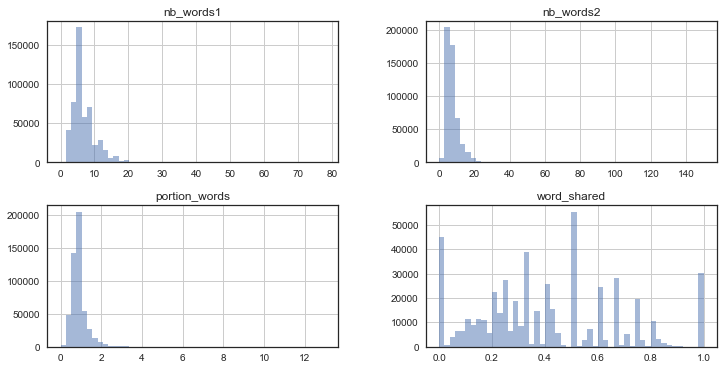

In [36]:
Df[['word_shared', 'nb_words1', 'nb_words2', 'portion_words']].hist(bins=50, color='b',figsize=(12,6), alpha=0.5)
plt.show()

Let us describe the features

In [37]:
Df[['word_shared', 'nb_words1', 'nb_words2', 'portion_words']].describe()

,word_shared,nb_words1,nb_words2,portion_words
count,510054.000000,510054.000000,510054.000000,510054.000000
mean,0.404977,6.925620,7.039225,0.918858
std,0.266564,3.485207,3.927988,0.414508
min,0.000000,0.000000,0.000000,0.000000
25%,0.200000,5.000000,5.000000,0.666667
50%,0.375000,6.000000,6.000000,0.833333
75%,0.600000,8.000000,8.000000,1.000000
max,1.000000,78.000000,150.000000,13.000000


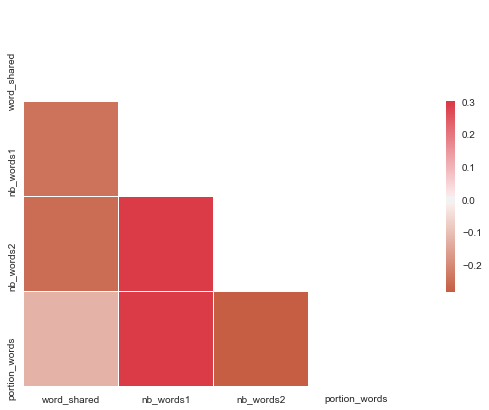

In [38]:
#I notice that these three features are uncorrelated
corr = Df[['word_shared', 'nb_words1', 'nb_words2', 'portion_words']].corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.set(style="white")

f, ax = plt.subplots(figsize=(15, 7))
cmap = sns.diverging_palette(20, 10, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.1, cbar_kws={"shrink": .5});

That is a good news

In [39]:
Dfviz = Df[['word_shared', 'nb_words1', 'nb_words2', 'portion_words', 'is_duplicate']]

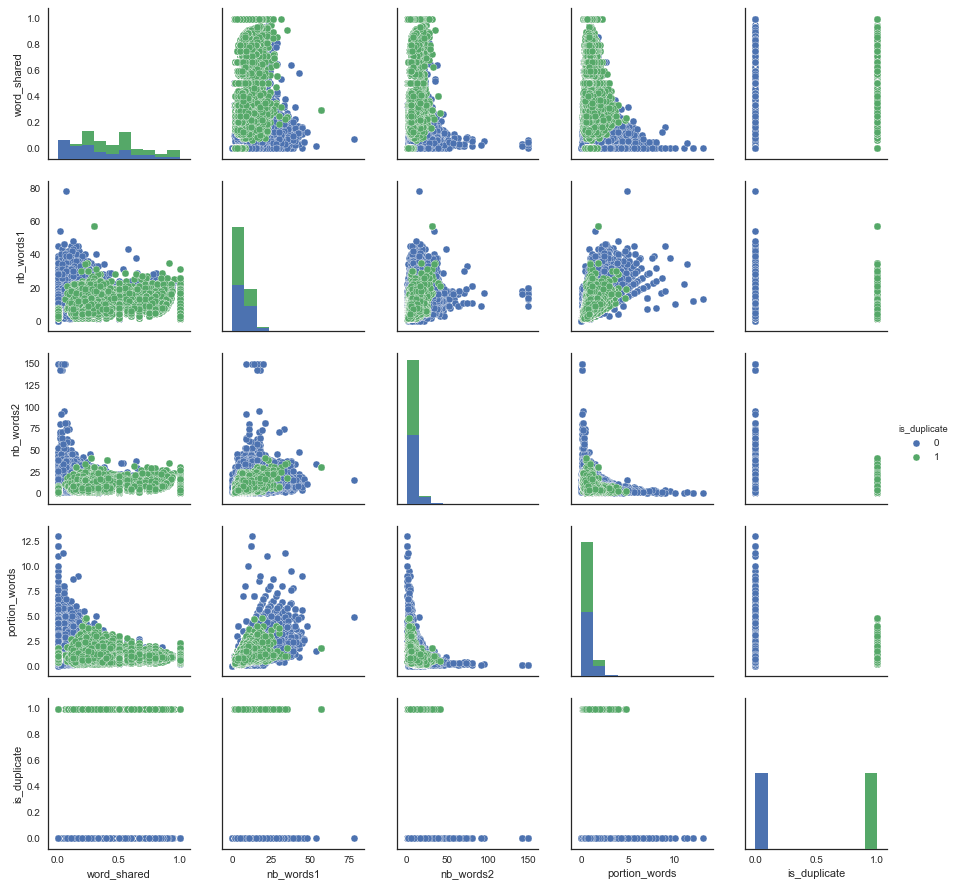

In [40]:
g = sns.pairplot(Dfviz, hue="is_duplicate")

Now, let 's look at the longest questions just for fun

Let 's look a the longest question in question1

In [41]:
DflongSentence1 = Df[Df['nb_words1']==78]

In [42]:
DflongSentence1['question1']

35101    Like everyone else (here in U.S), I work with ...
Name: question1, dtype: object

In [43]:
#The longuest question of question1
DflongSentence1['question1'].iloc[0]

'Like everyone else (here in U.S), I work with a group of people I see and interact with every day. As a human rights advocate and Lesbian, my views are liberal and I by no means preach my beliefs in my work place. However, I want to know, when is it OK to state your opinions on an issue. For example, if someone mentions that their next door neighbor, who happens to be a 12 year old boy, was playing with dolls and that "this is going down the wrong road and he is strange/weird", is it OK for me to say that we shouldn\'t judge him for who he is? So confused... This just happened at lunch and I am very upset about it...'

In [44]:
# The corresponding question in question2 of the longuest question in question1
DflongSentence1['question2'].iloc[0]

'When is it ok to force people to do things against their will if you are a liberal and wondering how much force you should advocate for?'

In [45]:
# They don't match
DflongSentence1['is_duplicate'].iloc[0]

0

The longuest question of question2

In [46]:
DflongSentence2 = Df[Df['nb_words2']==150]

In [47]:
# There are many questions in question2 with the maximal length
DflongSentence2['question2']

18055     Heartbreak? Heartbreak? She's my girlfriend fo...
51947     Heartbreak? Heartbreak? She's my girlfriend fo...
75727     Heartbreak? Heartbreak? She's my girlfriend fo...
94476     Heartbreak? Heartbreak? She's my girlfriend fo...
118582    Heartbreak? Heartbreak? She's my girlfriend fo...
130781    Heartbreak? Heartbreak? She's my girlfriend fo...
131653    Heartbreak? Heartbreak? She's my girlfriend fo...
166715    Heartbreak? Heartbreak? She's my girlfriend fo...
199362    Heartbreak? Heartbreak? She's my girlfriend fo...
237612    Heartbreak? Heartbreak? She's my girlfriend fo...
341117    Heartbreak? Heartbreak? She's my girlfriend fo...
377645    Heartbreak? Heartbreak? She's my girlfriend fo...
397439    Heartbreak? Heartbreak? She's my girlfriend fo...
Name: question2, dtype: object

In [48]:
# Let's look at the first one! It is clearly a long mail!
DflongSentence2['question2'].iloc[0]

"Heartbreak? Heartbreak? She's my girlfriend for two months, I chose her over my girlfriend for 2 years. I like her so much to the point that I can't let her go even if she wants to end our relationship because of the other people around us most especially her family. I do the things for her that I'm not used to for a girl and I am willing to sacrifice everything just to have a little time with her. A little and limited time that I'm asking from her but she don't wanna give it to me. She's scared that someone might see us, that she's still having an affair with me. I love her and I want to be with her at least once a week even if just for a limited time. I'm not sure if I'm doing the right thing, all of my friends told me to stop it and just let it go 2 months is just 2 months not a deep relationship. But they don't feel what I feel, in this span of time I learned a lot, I learned how to love, to be loved, to sacrifice a good life, and to sacrifice a better clear future. My mind tells 

In [49]:
# The corresponding question in question1 of the first longue question of question2
DflongSentence2['question1'].iloc[0]

"Im moving to NY. My Dr gave me 2 refills of Xanax, but pharmacy said by law, they couldn't give me more than 1 refill per month. Is it true?"

In [50]:
# They don't match.
DflongSentence2['is_duplicate'].iloc[0]

0

# 3.Models selection and hyperparameters tuning

We first define a function to evaluate the model performance

In [51]:
def evaluate(model, features, labels):  
    predictions = model.predict(features)
    errors = abs(predictions - labels)
    precision = precision_score(labels, predictions)*100
    recall = recall_score(labels, predictions)*100
    f1_Score = f1_score(labels, predictions)*100
    roc_auc = roc_auc_score(labels, predictions)*100
    accuracy = accuracy_score(labels, predictions)*100
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Recall = {:0.2f}%.'.format(recall))
    print('Precision = {:0.2f}%.'.format(precision))
    print('F1_score = {:0.2f}%.'.format(f1_Score))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    print('Roc_AUC = {:0.2f}%.'.format(roc_auc))
    
    return accuracy

## Logistic Regression
For Bunchmark, first  let's try logistic regression using just threse features to make a prediction.

In [52]:
X = Df[['word_shared', 'nb_words1', 'nb_words2', 'portion_words']]
y = Df['is_duplicate']

In [53]:
# We split data in train and dev set
X_train, X_dev, y_train, y_dev = train_test_split(X, y, test_size=0.30, random_state=42)

In [54]:
# Logistic Regression Model
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [55]:
print('Train measures')
log_reg_accuracy = evaluate(log_reg, X_train, y_train)

Train measures
Model Performance
Average Error: 0.3384 degrees.
Recall = 63.94%.
Precision = 66.95%.
F1_score = 65.41%.
Accuracy = 66.16%.
Roc_AUC = 66.16%.


In [56]:
print('Dev measures')
log_reg_accuracy = evaluate(log_reg, X_dev, y_dev)

Dev measures
Model Performance
Average Error: 0.3374 degrees.
Recall = 64.05%.
Precision = 66.92%.
F1_score = 65.46%.
Accuracy = 66.26%.
Roc_AUC = 66.26%.


It is not so bad!

## SVM

We try linear svm.

In [57]:
svm = LinearSVC()
svm.fit(X_train,y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [58]:
print('Train measures')
svm_accuracy = evaluate(svm, X_train, y_train)

Train measures
Model Performance
Average Error: 0.3394 degrees.
Recall = 63.45%.
Precision = 66.98%.
F1_score = 65.17%.
Accuracy = 66.06%.
Roc_AUC = 66.06%.


In [59]:
print('Dev measures')
svm_accuracy = evaluate(svm, X_dev, y_dev)

Dev measures
Model Performance
Average Error: 0.3382 degrees.
Recall = 63.56%.
Precision = 66.98%.
F1_score = 65.23%.
Accuracy = 66.18%.
Roc_AUC = 66.17%.


## Multinomial Naivebayes

 Here, we try Multinomial Navebayes.

In [60]:
multi_NB = MultinomialNB()
multi_NB.fit(X_train,y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [61]:
print('Train measures')
multi_NB_accuracy = evaluate(multi_NB, X_train, y_train)

Train measures
Model Performance
Average Error: 0.3357 degrees.
Recall = 71.33%.
Precision = 64.99%.
F1_score = 68.02%.
Accuracy = 66.43%.
Roc_AUC = 66.42%.


In [62]:
print('Dev measures')
multi_NB_accuracy = evaluate(multi_NB, X_dev, y_dev)

Dev measures
Model Performance
Average Error: 0.3348 degrees.
Recall = 71.60%.
Precision = 64.93%.
F1_score = 68.10%.
Accuracy = 66.52%.
Roc_AUC = 66.53%.


## Decision Tree
Now, let's try Decision Tree using just threse features to make a prediction.

Let's first analyze the different parameters of Decision Trees.

In [63]:
Clf_tree = DecisionTreeClassifier(max_depth=10)
Clf_tree.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [64]:
print('Train measures')
Clf_tree_accuracy = evaluate(Clf_tree, X_train, y_train)

Train measures
Model Performance
Average Error: 0.2686 degrees.
Recall = 91.45%.
Precision = 66.96%.
F1_score = 77.31%.
Accuracy = 73.14%.
Roc_AUC = 73.12%.


In [65]:
print('Dev measures')
Clf_tree_accuracy = evaluate(Clf_tree, X_dev, y_dev)

Dev measures
Model Performance
Average Error: 0.2709 degrees.
Recall = 91.25%.
Precision = 66.71%.
F1_score = 77.08%.
Accuracy = 72.91%.
Roc_AUC = 72.94%.


This tree model is more precise than logistic regression

So now, let's look at the parameters of Clf_tree

In [66]:
Clf_tree.get_params()

{'class_weight': None,
 'criterion': 'gini',
 'max_depth': 10,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': False,
 'random_state': None,
 'splitter': 'best'}

We plot accuracy score of tree in term of each parameter to visualize its trend

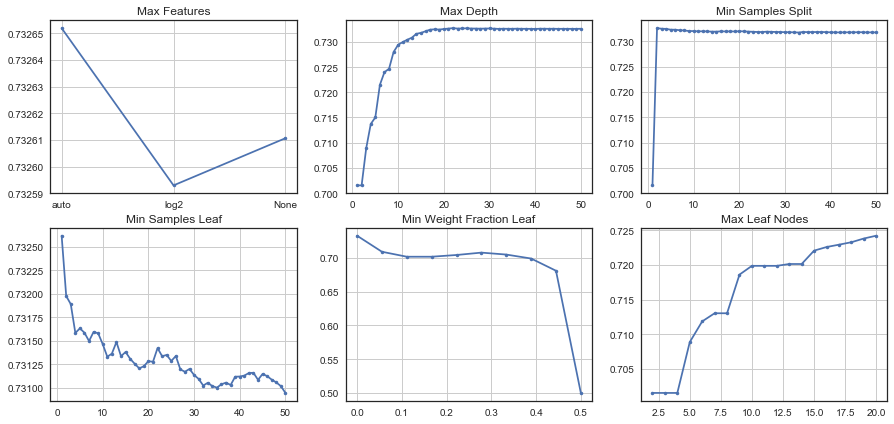

In [67]:
plt.figure(figsize=(15,7))

#Max Features
plt.subplot(2,3,1)
feature_param = ['auto','log2',None]
scores=[]
for feature in feature_param:
    clf = DecisionTreeClassifier(max_features=feature)
    clf.fit(X_train,y_train)
    scoreCV = cross_val_score(clf, X, y, cv= 5)
    scores.append(np.mean(scoreCV))
plt.plot(scores, '.-')
plt.axis('tight')
# plt.xlabel('parameter')
# plt.ylabel('score')
plt.title('Max Features')
plt.xticks(range(len(feature_param)), feature_param)
plt.grid();

#Max Depth
plt.subplot(2,3,2)
feature_param = range(1,51)
scores=[]
for feature in feature_param:
    clf = DecisionTreeClassifier(max_depth=feature)
    clf.fit(X_train,y_train)
    scoreCV = cross_val_score(clf, X, y, cv= 5)
    scores.append(np.mean(scoreCV))
plt.plot(feature_param, scores, '.-')
plt.axis('tight')
# plt.xlabel('parameter')
# plt.ylabel('score')
plt.title('Max Depth')
plt.grid();

#Min Samples Split
plt.subplot(2,3,3)
feature_param = [1.0] + list(range(2,51))
scores=[]
for feature in feature_param:
    clf = DecisionTreeClassifier(min_samples_split =feature)
    clf.fit(X_train,y_train)
    scoreCV = cross_val_score(clf, X, y, cv= 5)
    scores.append(np.mean(scoreCV))
plt.plot(feature_param, scores, '.-')
plt.axis('tight')
# plt.xlabel('parameter')
# plt.ylabel('score')
plt.title('Min Samples Split')
plt.grid();

#Min Samples Leaf
plt.subplot(2,3,4)
feature_param = range(1,51)
scores=[]
for feature in feature_param:
    clf = DecisionTreeClassifier(min_samples_leaf =feature)
    clf.fit(X_train,y_train)
    scoreCV = cross_val_score(clf, X, y, cv= 5)
    scores.append(np.mean(scoreCV))
plt.plot(feature_param, scores, '.-')
plt.axis('tight')
# plt.xlabel('parameter')
# plt.ylabel('score')
plt.title('Min Samples Leaf')
plt.grid();

#Min Weight Fraction Leaf
plt.subplot(2,3,5)
feature_param = np.linspace(0,0.5,10)
scores=[]
for feature in feature_param:
    clf = DecisionTreeClassifier(min_weight_fraction_leaf =feature)
    clf.fit(X_train,y_train)
    scoreCV = cross_val_score(clf, X, y, cv= 5)
    scores.append(np.mean(scoreCV))
plt.plot(feature_param, scores, '.-')
plt.axis('tight')
# plt.xlabel('parameter')
# plt.ylabel('score')
plt.title('Min Weight Fraction Leaf')
plt.grid();

#Max Leaf Nodes
plt.subplot(2,3,6)
feature_param = range(2,21)
scores=[]
for feature in feature_param:
    clf = DecisionTreeClassifier(max_leaf_nodes=feature)
    clf.fit(X_train,y_train)
    scoreCV = cross_val_score(clf, X, y, cv= 5)
    scores.append(np.mean(scoreCV))
plt.plot(feature_param, scores, '.-')
plt.axis('tight')
# plt.xlabel('parameter')
# plt.ylabel('score')
plt.title('Max Leaf Nodes')
plt.grid()

These figure help us to restrict our window of hyper parameters. After this, we use RandomGridSearch to tune hyperparameter of tree model for our data

In [68]:
# Construction of dictionary's elements of GridSearch

# Number of criterion
criterion = ['gini', 'entropy']
# Number of features to consider at every split
max_features = ['auto', 'sqrt', None]
# Maximum number of leaf node in tree
max_leaf_nodes = [int(x) for x in np.linspace(15, 21, num = 7)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(15, 35, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 3, 4, 5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [int(x) for x in np.linspace(1, 5, num = 5)]

In [69]:
# We create Tree grid
tree_grid = {'criterion': criterion,
               'max_features': max_features,
               'max_leaf_nodes': max_leaf_nodes,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               }
print(tree_grid)

{'max_leaf_nodes': [15, 16, 17, 18, 19, 20, 21], 'criterion': ['gini', 'entropy'], 'min_samples_leaf': [1, 2, 3, 4, 5], 'min_samples_split': [2, 3, 4, 5], 'max_depth': [15, 17, 19, 21, 23, 26, 28, 30, 32, 35, None], 'max_features': ['auto', 'sqrt', None]}


In [70]:
# Use the Tree grid to search the best hyperparameters
# First create the base model to tune
dc_clf = DecisionTreeClassifier()
# search across 150 different combinations, and use 4 cores
tree_clf = RandomizedSearchCV(estimator = dc_clf, param_distributions = tree_grid, n_iter = 150, cv = 3, verbose=2, random_state=42, n_jobs = 4)
# Fit the random search model
tree_clf.fit(X_train, y_train)

Fitting 3 folds for each of 150 candidates, totalling 450 fits


[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    5.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:   18.1s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:   40.0s
[Parallel(n_jobs=4)]: Done 450 out of 450 | elapsed:   50.1s finished


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          fit_params=None, iid=True, n_iter=150, n_jobs=4,
          param_distributions={'max_leaf_nodes': [15, 16, 17, 18, 19, 20, 21], 'criterion': ['gini', 'entropy'], 'min_samples_leaf': [1, 2, 3, 4, 5], 'min_samples_split': [2, 3, 4, 5], 'max_depth': [15, 17, 19, 21, 23, 26, 28, 30, 32, 35, None], 'max_features': ['auto', 'sqrt', None]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [71]:
tree_clf.best_params_

{'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': 21,
 'min_samples_leaf': 3,
 'min_samples_split': 2}

In [72]:
best_tree = tree_clf.best_estimator_

In [73]:
print('Train measures')
best_teree_accuracy = evaluate(best_tree, X_train, y_train)

Train measures
Model Performance
Average Error: 0.2746 degrees.
Recall = 92.91%.
Precision = 66.03%.
F1_score = 77.20%.
Accuracy = 72.54%.
Roc_AUC = 72.52%.


In [74]:
print('Dev measures')
best_teree_accuracy = evaluate(best_tree, X_dev, y_dev)

Dev measures
Model Performance
Average Error: 0.2751 degrees.
Recall = 92.90%.
Precision = 65.93%.
F1_score = 77.12%.
Accuracy = 72.49%.
Roc_AUC = 72.53%.


We have better result with decision tree

## RandomForest

After looking at the performance of the best tree we found, we can expect to improve the result checking the performance of the best randomforest model we shall search. Let's start with the dictionnary of parameters.

In [75]:
# Contruction of dictionary's elements of GridSearch

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 60, stop = 500, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 3, 4, 5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 3, 4, 5]
# Method of selecting samples for training each tree
bootstrap = [True, False]

In [76]:
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'bootstrap': [True, False], 'min_samples_leaf': [1, 2, 3, 4, 5], 'min_samples_split': [2, 3, 4, 5], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'max_features': ['auto', 'sqrt'], 'n_estimators': [60, 108, 157, 206, 255, 304, 353, 402, 451, 500]}


In [77]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use 4 cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = 4)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed: 13.1min
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed: 59.7min
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed: 125.3min finished


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid=True, n_iter=100, n_jobs=4,
          param_distributions={'bootstrap': [True, False], 'min_samples_leaf': [1, 2, 3, 4, 5], 'min_samples_split': [2, 3, 4, 5], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'max_features': ['auto', 'sqrt'], 'n_estimators': [60, 108, 157, 206, 255, 304, 353, 402, 451, 500]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [78]:
rf_random.best_params_

{'bootstrap': False,
 'max_depth': 20,
 'max_features': 'auto',
 'min_samples_leaf': 5,
 'min_samples_split': 5,
 'n_estimators': 108}

In [79]:
best_random = rf_random.best_estimator_

In [80]:
print('Train measures')
best_random_accuracy = evaluate(best_random, X_train, y_train)

Train measures
Model Performance
Average Error: 0.2598 degrees.
Recall = 91.40%.
Precision = 67.84%.
F1_score = 77.88%.
Accuracy = 74.02%.
Roc_AUC = 74.00%.


In [81]:
print('Dev measures')
random_accuracy = evaluate(best_random, X_dev, y_dev)

Dev measures
Model Performance
Average Error: 0.2678 degrees.
Recall = 90.63%.
Precision = 67.17%.
F1_score = 77.16%.
Accuracy = 73.22%.
Roc_AUC = 73.25%.


Here we compare metrics of models selected. We will visualize these performances

In [82]:
# We gather our models into a list
Models = [log_reg, svm, multi_NB, best_tree, best_random]
models = ['log_reg', 'svm', 'multi_NB', 'best_tree', 'best_random']

In [83]:
# We collect metrics we need in a dictionnary
def metrics(Models, features, labels):
    Precision = []
    Recall = []
    F1_Score = []
    Accuracy = []
    Roc_AUC = []
    for model in Models:
        predictions = model.predict(features)
        precision = precision_score(labels, predictions)*100
        recall = recall_score(labels, predictions)*100
        f1_Score = f1_score(labels, predictions)*100
        roc_auc = roc_auc_score(labels, predictions)*100
        accuracy = accuracy_score(labels, predictions)*100
        Precision.append(precision)
        Recall.append(recall)
        F1_Score.append(f1_Score)
        Accuracy.append(accuracy)
        Roc_AUC.append(roc_auc)
    dict = {'Models': Models, 
            'Precision': Precision, 
            'Recall': Recall, 
            'F1_Score': F1_Score, 
            'Accuracy': Accuracy, 
            'Roc_AUC': Roc_AUC}
    return dict 
    

In [84]:
train_metrics = metrics(Models, X_train, y_train)
dev_metrics = metrics(Models, X_dev, y_dev)
df_train_metrics = pd.DataFrame(data=train_metrics)
df_dev_metrics = pd.DataFrame(data=dev_metrics)

In [85]:
df_train_metrics['Models'] = models
df_dev_metrics['Models'] = models

In [86]:
df_train_metrics = df_train_metrics[['Models', 'Precision', 'Recall', 'F1_Score', 'Accuracy','Roc_AUC']]
df_dev_metrics = df_dev_metrics[['Models', 'Precision', 'Recall', 'F1_Score', 'Accuracy','Roc_AUC']]


In [87]:
df_train_metrics

,Models,Precision,Recall,F1_Score,Accuracy,Roc_AUC
0,log_reg,66.946972,63.944006,65.411041,66.159810,66.161580
1,svm,66.983958,63.453692,65.171052,66.061781,66.063864
2,multi_NB,64.992300,71.333979,68.015637,66.428409,66.424490
3,best_tree,66.033225,92.909477,77.199045,72.537020,72.520745
4,best_random,67.843373,91.401593,77.879917,74.018659,74.004772


Visualization of train metrics

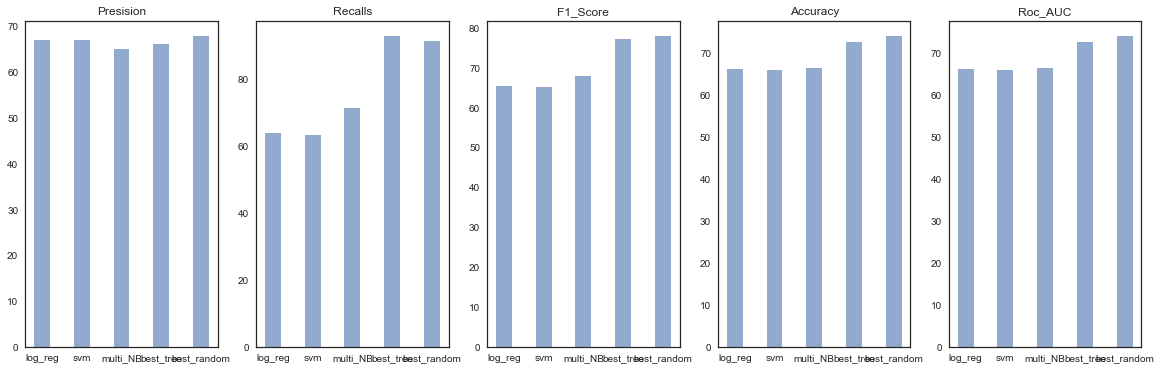

In [88]:
plt.figure(figsize=(20,6))

#Precisions bar plot
plt.subplot(1,5,1)
plt.bar(models,df_train_metrics['Precision'], color='b', alpha=0.6, width=0.4)
plt.title('Presision')

#Recalls bar plot
plt.subplot(1,5,2)
plt.bar(models,df_train_metrics['Recall'], color='b', alpha=0.6, width=0.4)
plt.title('Recalls')

#F1_Scores of our models
plt.subplot(1,5,3)
plt.bar(models,df_train_metrics['F1_Score'], color='b', alpha=0.6, width=0.4)
plt.title('F1_Score')


#Accuracies bar plot
plt.subplot(1,5,4)
plt.bar(models,df_train_metrics['Accuracy'], color='b', alpha=0.6, width=0.4)
plt.title('Accuracy')

#Roc_AUC bar plot
plt.subplot(1,5,5)
plt.bar(models,df_train_metrics['Roc_AUC'], color='b', alpha=0.6, width=0.4)
plt.title('Roc_AUC')

plt.show()

In [89]:
df_dev_metrics 

,Models,Precision,Recall,F1_Score,Accuracy,Roc_AUC
0,log_reg,66.922056,64.052065,65.455616,66.259305,66.255201
1,svm,66.983163,63.557080,65.225162,66.177614,66.172742
2,multi_NB,64.927509,71.602546,68.101854,66.524635,66.534075
3,best_tree,65.927551,92.897363,77.122606,72.494559,72.532490
4,best_random,67.172639,90.631957,77.158560,73.219969,73.252339


Visualization of train metrics

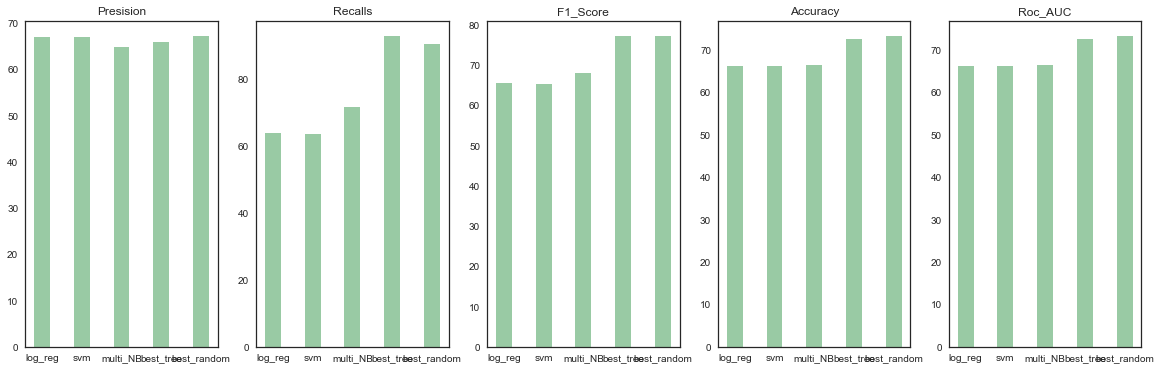

In [90]:
plt.figure(figsize=(20,6))

#Precisions bar plot
plt.subplot(1,5,1)
plt.bar(models,df_dev_metrics['Precision'], color='g', alpha=0.6, width=0.4)
plt.title('Presision')

#Recalls bar plot
plt.subplot(1,5,2)
plt.bar(models,df_dev_metrics['Recall'], color='g', alpha=0.6, width=0.4)
plt.title('Recalls')

#F1_Scores of our models
plt.subplot(1,5,3)
plt.bar(models,df_dev_metrics['F1_Score'], color='g', alpha=0.6, width=0.4)
plt.title('F1_Score')


#Accuracies bar plot
plt.subplot(1,5,4)
plt.bar(models,df_dev_metrics['Accuracy'], color='g', alpha=0.6, width=0.4)
plt.title('Accuracy')

#Roc_AUC bar plot
plt.subplot(1,5,5)
plt.bar(models,df_dev_metrics['Roc_AUC'], color='g', alpha=0.6, width=0.4)
plt.title('Roc_AUC')

plt.show()



It is clear that best_random is the best model for this study.

# Submission

In [91]:
test_features = test[['word_shared', 'nb_words1', 'nb_words2', 'portion_words']]

In [92]:
submission = best_random.predict(test_features)

In [93]:
repartition = list(submission)

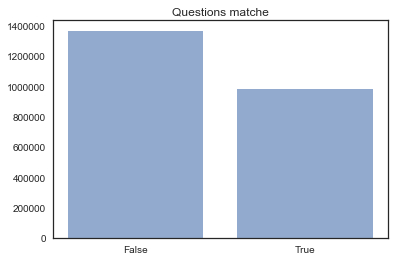

In [94]:
plt.bar(['False', 'True'],[repartition.count(0), repartition.count(1)], alpha=0.6)
plt.title('Questions matche')
plt.show()

For further work we will try for feauturing TF-IDF and word2vec. We will also try Neural Network models 